In [42]:
#Importing used libraries
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly

### Displaying initial columns in cleaned data

In [43]:

df = pd.read_csv('../data/lrpd-clean.csv')
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'])
df.head().T


,0,1,2,3,4
INCIDENT_NUMBER,2021-092971,2017-029450,2017-156453,2019-130717,2020-073313
INCIDENT_DATE,2021-08-04 10:21:00,2017-03-16 18:30:00,2017-09-01 12:00:00,2019-10-17 21:00:00,2020-07-02 19:10:00
LOCATION_DISTRICT,72.0,82.0,53.0,51.0,50.0
OFFENSE_DESCRIPTION,THEFT FROM MOTOR VEHICLE,THEFT OF MOTOR VEHICLE PARTS,RAPE,RAPE,RAPE
WEAPON_TYPE,NO WEAPON,NO WEAPON,NO WEAPON,NO WEAPON,NO WEAPON
ZIP,72204.0,72206.0,0.0,0.0,0.0
LATITUDE,0.0,34.649362,0.0,0.0,0.0
LONGITUDE,0.0,-92.301959,0.0,0.0,0.0
WEEK_OF_MONTH,0,2,0,2,0
YEAR,2021,2017,2017,2019,2020


### Creating a new dataframe containing daily counts of incidents and renaming columns according to Prophet's requirements

In [44]:
df2 = df.groupby(pd.Grouper(key='INCIDENT_DATE', freq='D')).size().reset_index(name='INCIDENT_COUNT')
df2.columns = ['ds', 'y']
df2.tail()

,ds,y
2112,2022-10-14,49
2113,2022-10-15,28
2114,2022-10-16,31
2115,2022-10-17,47
2116,2022-10-18,35


<AxesSubplot:xlabel='ds'>

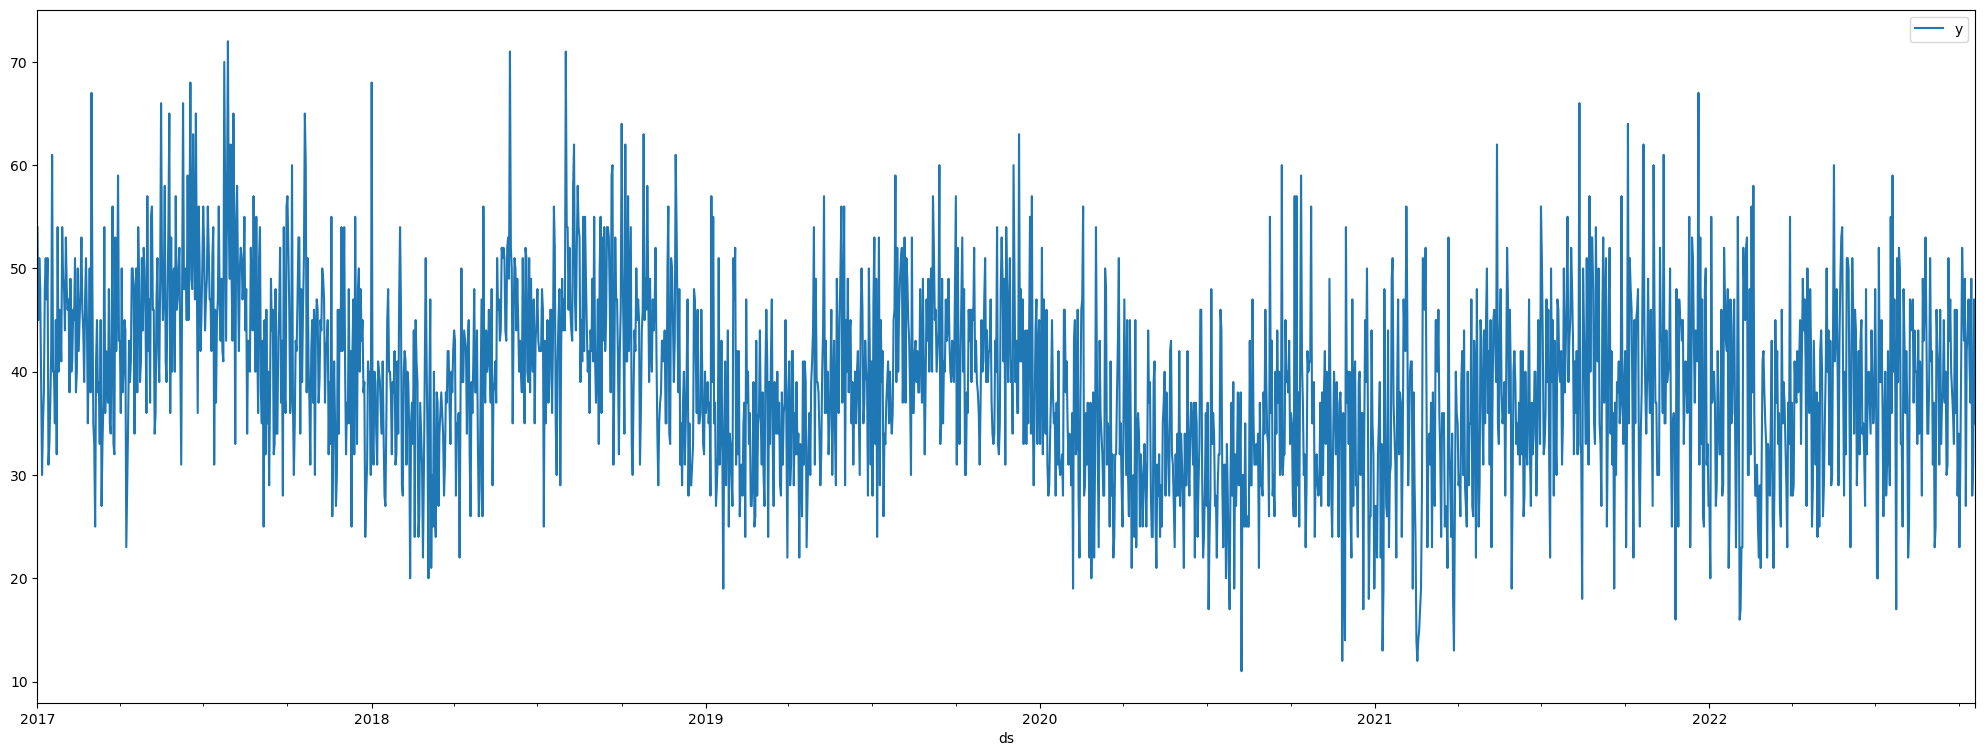

In [45]:
df2.set_index('ds').plot(figsize=(25, 9))

### Importing holidays from the holidays library and converting it to a dataframe to be used for Prophet model

In [46]:
import holidays

us_holidays = holidays.UnitedStates(years=[2017, 2018, 2019, 2020, 2021, 2022, 2023])
us_holidays = pd.DataFrame.from_dict(us_holidays, orient='index').reset_index()
us_holidays.columns = ['ds', 'holiday']
us_holidays['ds'] = pd.to_datetime(us_holidays['ds'])
us_holidays.tail()


,ds,holiday
80,2023-10-09,Columbus Day
81,2023-11-11,Veterans Day
82,2023-11-10,Veterans Day (Observed)
83,2023-11-23,Thanksgiving
84,2023-12-25,Christmas Day


### Setting train and test data as 80% and 20% of the dataset respectively.

In [47]:
train = df2[:int(0.8 * (len(df2)))]
test = df2[int(0.8 * (len(df2))):]
train.tail(), test.head()

(             ds   y
 1688 2021-08-16  50
 1689 2021-08-17  44
 1690 2021-08-18  39
 1691 2021-08-19  33
 1692 2021-08-20  51,
              ds   y
 1693 2021-08-21  40
 1694 2021-08-22  31
 1695 2021-08-23  57
 1696 2021-08-24  40
 1697 2021-08-25  53)

### Fitting the Prophet model with train data using optimally tuned hyperparameters and holidays dataframe.

In [48]:
m = Prophet(
    holidays=us_holidays,
    yearly_seasonality=True,
    holidays_prior_scale=1,
    seasonality_prior_scale=0.1,
    seasonality_mode='multiplicative',
)

m.fit(train)
future = m.make_future_dataframe(periods=test.shape[0])
forecast = m.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
2112,2022-10-14,49.057977,38.660117,59.915979
2113,2022-10-15,44.777369,33.972950,55.278029
2114,2022-10-16,41.759837,31.729601,51.295441
2115,2022-10-17,49.286825,38.312449,59.221991
2116,2022-10-18,46.765671,36.686652,57.186077


### Plotting the forecast along with actual values in test data.

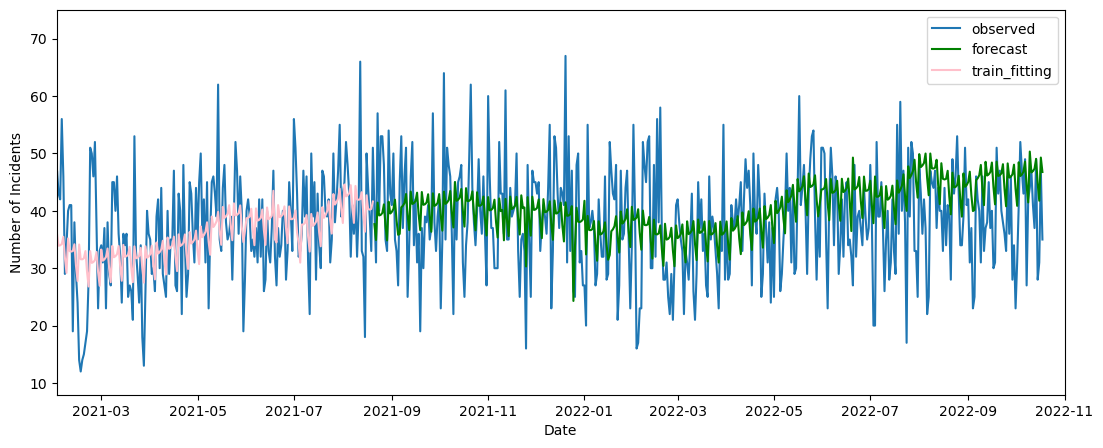

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
plt.plot(df2.ds, df2.y, label='observed')

plt.plot(forecast[int(0.8 * (len(forecast))):]['ds'], forecast[int(0.8 * (len(forecast))):]['yhat'],
         label='forecast', color='green')
plt.plot(forecast[:int(0.8 * (len(forecast)))]['ds'], forecast[:int(0.8 * (len(forecast)))]['yhat'],
         label='train_fitting', color='pink')

plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.xlim(pd.Timestamp('2021-02-01'), pd.Timestamp('2022-11-01'))
plt.show()

In [50]:
test = test.merge(forecast[['ds', 'yhat']], how='left', on='ds')

### Plotting the forecast and visualizing possible seasonality of crimes.

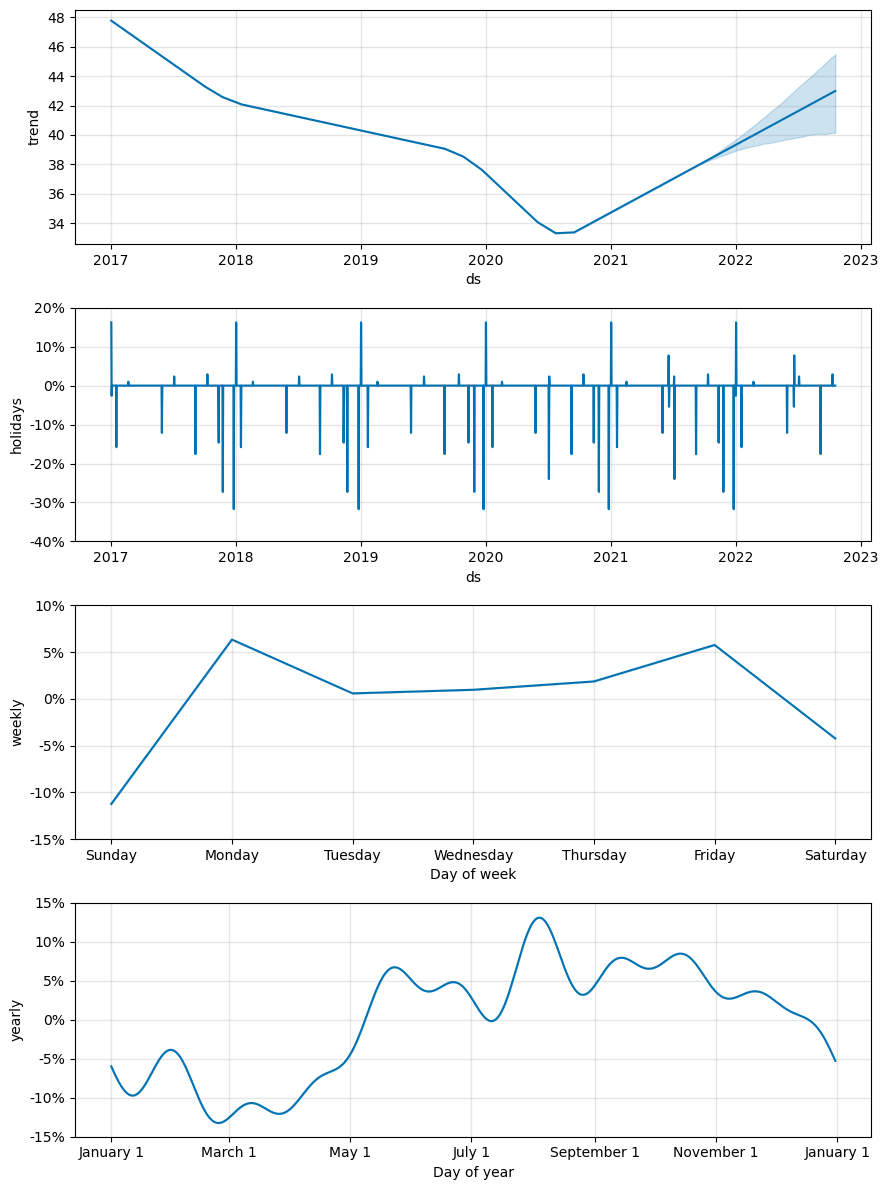

In [51]:
pt = m.plot_components(forecast)

In [52]:
plot_plotly(m, forecast, xlabel='Date', ylabel='Number of Incidents')


### Evaluating the model


In [53]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

predictions = test['yhat']
actual = test['y']

print('RMSE: ', rmse(actual, predictions))
print('MSE: ', mean_squared_error(actual, predictions))
print('MAE: ', mean_absolute_error(actual, predictions))
print('R2: ', r2_score(actual, predictions))

RMSE:  8.711217153542265
MSE:  75.88530429616901
MAE:  6.8735243939541455
R2:  0.08700757350674715
